# The Hilbert–Kunz multiplicity of an $A_n$ singularity.
..

In [1]:
def lam(p,k):
    a = (p-1)/2
    if p%2 == 0 or k>p-1:
        return 'The first argument needs to be odd and the second must be strictly smaller.'
    l = []
    for i in range(p):
        for j in range(p):
            if j>=i and i+j<=p-1:
                i0 = i
                j0 = j
                x = lambda k: 1 if j0-i0<=k<=i0+j0 else 0
                lij = [x(k) for k in range(p)]
                l.append(lij)
            elif j-i >= 0:
                i0 = p-1-j
                j0 = p-1-i
                x = lambda k: 1 if j0-i0<=k<=i0+j0 else 0
                lij = [x(k) for k in range(p)]
                l.append(lij)
            else:
                j0 = i
                i0 = j
                if i0+j0<=p-1:
                    x = lambda k: 1 if j0-i0<=k<=i0+j0 else 0
                    lij = [x(k) for k in range(p)]
                    l.append(lij)
                else:
                    i1 = p-1-j0
                    j1 = p-1-i0
                    x = lambda k: 1 if j1-i1<=k<=i1+j1 else 0
                    lij = [x(k) for k in range(p)]
                    l.append(lij)
    l = [matrix([l[i+p*k] for i in range(p)]).transpose() for k in range(p)]
    return l[k]


def theta(p,M0):
    '''
    This function takes lambda_k in Lambda_n (as the matrix M0) and outputs the matrix of theta(lambda_k)
    in Lambda_n+1.
    '''
    n = int(log(M0.nrows())/log(p))
    error = 0
    k = list(M0[0]).index(1) #This is to detect which lambda the matrix M0 is representing. But this is easy.
    # It is just the location of the 1 in the first row/column. That's what this line does.
    # This is important to check parity on the next line:
    if k%2!=0: error = 1 # This is for parity.
    M = zero_matrix(p**(n+1),p**(n+1)) # I wouldn't say that these matrices are sparse...
    for a in range(p):
        for i in range(p**n): # We first give the values at elements lambda_ip
            for j in range(p**n):
                # lambda_kp lambda_ip = lambda_error_k * lambda_error_i * theta(lambda_k * lambda_i) =
                # = lambda_error_k * lambda_error_i * sum theta(lambda_j) 
                # = lambda_error_k * lambda_error_i * sum lambda_(pj+error_j)
                if i%2 == 0:
                    if j%2 == 0:
                        M[p*j+error*(p-1)+(-1)**error*a,p*i+a] = M0[j,i]
                    else:
                        M[p*j+p-1-error*(p-1)+(-1)**(1-error)*a,p*i+a] = M0[j,i]
                else:
                    # i is odd now...
                    if j%2 == 0:
                        M[p*j+p-1-error*(p-1)+(-1)**(1-error)*a,p*i+a] = M0[j,i]
                    else:
                        M[p*j+error*(p-1)+(-1)**error*a,p*i+a] = M0[j,i]
    return M

def scaler(p,M0):
    # This function takes the matrix of lambda_k in Lambda_n and gives you the matrix of lambda_k in Lambda_n+1
    return identity_matrix(p).tensor_product(M0)

def p_adic(p,n,k): # digits in base p as list [a_0,a_1,...] for a_0+a_1p+...
    k_p = []
    while k > 0:
        k_p.append(k%p)
        k = k//p
    if n>len(k_p):
        k_p = k_p + [0 for _ in range(n-len(k_p))]
    return k_p
# I need to check the error adjusments like p-1-error*(p-1)+(-1)**(1-error)*a. But it seems experimentally fine
#print((theta(p,theta(p,lam(p,k)))*scaler(3,scaler(3,lam(p,k)))).str(),'\n',scaler(3,scaler(3,lam(p,k))).str())

def lambda_matrix(p,n,k):
    if k>=p**n:
        return 'lambda_'+str(k)+'is not in Lambda_'+str(n)
    p_ad = p_adic(p,n,k)
    M = identity_matrix(p**n)
    for i in range(n): #len(p_ad) should be n!!
        Mi = lam(p,p_ad[i])
        for _ in range(i):
            Mi = theta(p,Mi)
        for _ in range(n-i-1):
            Mi = scaler(p,Mi)
        M = M*Mi
    return M

def vertical_swap(M):
    a = M.nrows()
    return matrix([[M[a-j-1,i] for i in range(a)] for j in range(a)])

def N_a(p,n):
    a = int((p**n-1)/2)
    return sum((-1)**k*2*lambda_matrix(p,n,k) for k in range(a))+(-1)**a*lambda_matrix(p,n,a)
def N_a_faster(p,n):
    '''
    I already know that this has a formula, so I should do a function that builds the matrix
    directly, and not from definition!
    '''
    return

def find_mu_e0(p,n,dim):
    '''
    The Han–Monsky's algorithm takes the exponents of a diagonal hypersurface, the characteristic,
    and a certain mu. If the correct mu is chosen, then the algorithm yields an expression for the
    Hilbert–Kunz function of the diagonal hypersurface that works for every e≥e_0 for a certain e_0.
    
    It can be seen that n+1 = c*p**e0 where gcd(c,p) = 1.
    
    This function computes the least mu such that p**mu = ± 1 (mod c). (see [HM93], Theorem 5.2)
    '''
    e0 = 0
    mu = 1
    while (n+1)%p**(e0+1) == 0: # This part of the function computes e0
        # e0 is the largest e such that p**e divides n+1
        # print((n+1)%p**(e0+1))
        e0 += 1
    c = (n+1)/p**e0
    if c!=1:
        #I think mu can be computed just thinking about the multiplicative group of units of Z/cZ
        while p**mu%c != 1 and p**mu%c != c-1%c: # But this computes it trying one by one
            # print(p**mu%c)
            mu+=1
    return mu,e0,c
    
def eHKAn(p,n,dim):
    '''
    Once you find the correct e0 and mu, then to compute the Hilbert–Kunz function one needs to
    use matrices and apply a formula.
    '''
    if p == 2:
        return 'There is a formula for this'
    mu,e0,c = find_mu_e0(p,n,dim) 
    # n+1 = cp**e0
    # e0 is a shift needed in case n+1 is multiple of p
    # mu is the period
    beta = p**e0/(n+1)
    z = beta-floor(beta)
    z1 = p**mu*beta-floor(p**mu*beta)
    a = int((p**mu-1)/2)
    b = 0
    if c!=1:
        b = floor(p**(mu+e0)/(n+1))
    # print(mu,e0,c,z,z1,a,b)
    lsh = (lambda_matrix(p,mu,a)**dim*lambda_matrix(p,mu,b))[0,0]
    N_b = sum((-1)**k*c*lambda_matrix(p,mu+e0,k) for k in range(floor(p**mu/c)))+(-1)**(floor(p**mu/c))*(p**mu%c)*lambda_matrix(p,mu+e0,floor(p**mu/c))
    HK1 = p**e0*(N_a(p,e0)**dim)[0,0] # Ok
    HK2 = p**e0*((N_a(p,e0+mu)**dim)*N_b)[0,0] #If mu is greater than 3, this is already too big for p≥7.
    return (HK2 - HK1*lsh)/(p**(mu*dim)-lsh)/p**(e0*dim)#,(HK1)/(p**((e0)*dim))

def cd(d):
    return (1/cos(x)+tan(x))[d]

n = 2#int(input('Introduce the A_n singularity you want to study (e.g. input 1 to study A_1)'))
d = 4#int(input('Introduce the dimension'))
p = 5#int(input('Introduce the characteristic'))
[float(eHKAn(2*m+1,5,4)) for m in [2,3,5,6]]

[1.3225806451612903,
 1.3187919463087248,
 1.3175472214618122,
 1.3171039708152097]

# $e_\text{HK}$ of $A_n$ singularities when varying $p$.

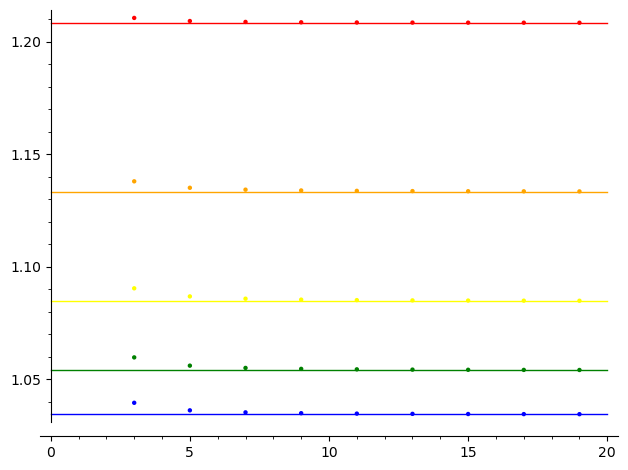

In [11]:
n = 1
d0 = 4
dmax = d0+5
p0 = 1 #p0 = 0 hace que aparezca el valor en caracteristica 2
pmax = 10
eHKs = [[(2*m+1,eHKAn(2*m+1,n,d)) for m in range(1,pmax)] for d in range(d0,dmax)]
colors = ['red','orange','yellow','green','blue','purple','pink','brown']
R.<x>=PowerSeriesRing(QQ,'x')
lowerbounds = [1+cd(k) for k in range(d0,dmax)]
(sum(points(eHKs[r],color = colors[r])+plot(lowerbounds[r],(x,0,2*pmax),color = colors[r]) for r in range(dmax-d0))).show()

# Experiments to tackle the monotonicity of $e_\text{HK}{R_{p,d}}$ as a function of $p$.
I have taken the matrices $N_{p_1^2}$ and $N_{p_2^2}$ for $p_1>p_2$ consecutive odd numbers up to 19, and computed the 1,1 element of powers up to $d = 500$ or more. In all cases, the inequality holded. Thus, it seems like the result does not depend on dimension that much, and that the only bad one is the case of $\operatorname{HK}_1$, because the rest of $\operatorname{HK}_e/p^{de}$ do seem to form decreasing sequences for all $e\geq 2$, for all $d\geq 4$, regardless of dimension. This is weird, I would not expect this. So my guess is: let us try to prove the monotonicity in the case of $e=2$, and let us see if that shows what is happening.

The only thing is that the inequalities are not true in dimension $2$ and $3$. But in dimension $4$ and onward, they seem true for every $e\geq 2$, interestingly. But it is good to bear in mind that we don't really need to prove it for all $e\geq 2$ but just for all large enough $e$.


In [109]:
prime_iterator = iter(Primes())
next(prime_iterator)
p1,p2 = next(prime_iterator),next(prime_iterator)

In [112]:
e = 2
d = 4
#p1,p2 = 3,5
Np1,Np2 = N_a(p1,e)/p1^e,N_a(p2,e)/p2^e
hkap,hkbp = (N_a(p1,e)*Np1^d)[0,0],(N_a(p2,e)*Np2^d)[0,0]
print(p1,p2,hkap,hkbp,hkap>hkbp)
p1,p2 = p2,next(prime_iterator)

7 11 6968097/5764801 259052961/214358881 True


In [69]:
d = 4
print([6737/6561>79277/78125,6737/6561>17737/15625,6737/6561>141/125,6737/6561>17513/15625,6737/6561>87229/78125])
print(Np1^(d+1)/p1^(d*e))
print(Np2^(d+1)/p2^(d*e))

[True, False, False, False, False]
[ 259052961/815730721 -259038321/815730721  259010017/815730721 -258970001/815730721  258921201/815730721 -258867521/815730721    19908757/62748517 -258765041/815730721    19901925/62748517 -258696721/815730721  258682081/815730721 -255897841/815730721  255854881/815730721 -255771825/815730721  255654401/815730721 -255511201/815730721  255353681/815730721 -255196161/815730721  255052961/815730721 -254935537/815730721    19604037/62748517 -254809521/815730721  249426657/815730721 -249358257/815730721  249226017/815730721 -249039057/815730721  248811057/815730721 -248560257/815730721  248309457/815730721   -19083189/62748517  247894497/815730721 -247762257/815730721  247693857/815730721 -240083601/815730721  239994561/815730721 -239822417/815730721    18429157/62748517 -239282241/815730721  238955761/815730721 -238629281/815730721  238332481/815730721 -238089105/815730721  237916961/815730721 -237827921/815730721  228547121/815730721 -228444161/81573072

# Quickest way of computing $\text{HK}_e(R_{p,d})$ for given $p,d$.

In [305]:
def HK1A1_brute_force(p,d):
    vars = var(['x%d'%i for i in range(d+1)])
    R = PolynomialRing(GF(p),vars)
    I = R.ideal([sum(var('x%d'%i)^2 for i in range(d+1))]+[var('x%d'%i)^(p) for i in range(d+1)])
    #print(I)
    return I.vector_space_dimension()
def Na(p):
    a = (p-1)/2
    return 2*sum((-1)^k*lam(p,k) for k in range(a))+(-1)^a*lam(p,a)
def HK1A1(p,d): #Via Han–Monsky
    return (Na(p)^(d+1))[0,0]
def lsharpA1(p,d):
    a = floor(p/2)
    return (lam(p,a)^(d+1))[0,0]
def eHKA1(p,d,brute_force=False):
    '''
    There are two equally fast ways of computing HK_1: the Han–Monsky way, or the brute force way.
    These are the two options between which the brute_force boolean chooses.
    '''
    if brute_force:
        return 1+(HK1A1_brute_force(p,d)-p^d)/(p^d-lsharpA1(p,d))
    return 1+(HK1A1(p,d)-p^d)/(p^d-lsharpA1(p,d))
prime_iterator = iter(Primes())
next(prime_iterator)
p2 = next(prime_iterator)

In [334]:
#p1,p2 = p2, next(prime_iterator)
d = 4
e = 2
def HKeA1(p,d,e,brute_force=False):
    return eHKA1(p,d,brute_force)*p^(d*e)-(eHKA1(p,d,brute_force)-1)*lsharpA1(p,d)^e
HKeA1(p1,d,e)/p1^(d*e)>HKeA1(p2,d,e)/p2^(d*e),p1,p2,eHKA1(p1,d)>eHKA1(p2,d)

(True, 29, 31, True)